# Map 8 - Folds, fault and unconformity

In [1]:
# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

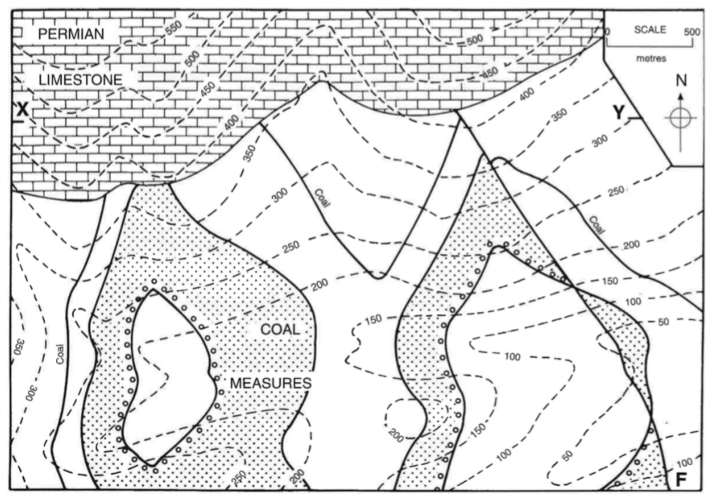

In [2]:
# Display map
img = mpimg.imread('map8.png')
plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.axis('off')
plt.tight_layout()

In [3]:
# Import other required libraries
import geopandas as gpd
import rasterio
import gemgis as gg
import os

In [4]:
# Get current directory
current_directory = os.getcwd()

In [5]:
# Read topographic contours
topo = gpd.read_file(filename = current_directory+"/contours/contours.shp")
topo.head()

,X,Y,Z,geometry
0,4019.98,339.50,50,POINT (4019.983 339.500)
1,3951.29,334.53,50,POINT (3951.291 334.532)
2,3897.71,317.57,50,POINT (3897.709 317.568)
3,3841.43,306.20,50,POINT (3841.432 306.197)
4,3780.37,284.69,50,POINT (3780.369 284.689)


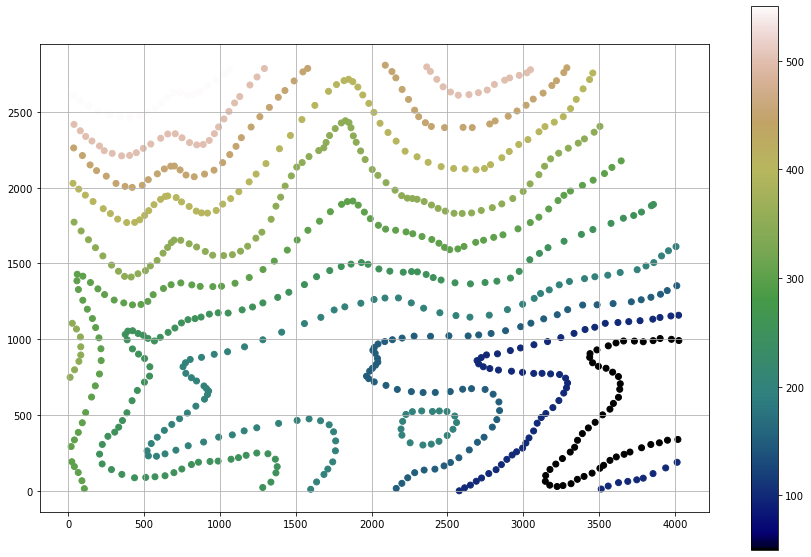

In [6]:
# Plot contours
fix, ax = plt.subplots(1, figsize=(15, 10))
topo.plot(ax=ax, aspect='equal',column='Z', cmap='gist_earth', legend=True)
plt.grid()

In [7]:
# Interpolate contours to make DEM
topo_raster = gg.vector.interpolate_raster(gdf=topo,value='Z',method='rbf',res=5)

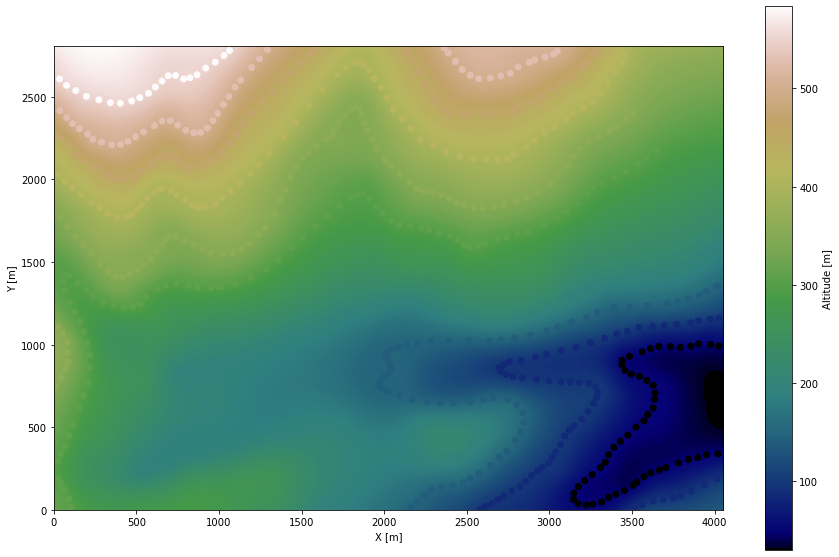

In [8]:
# Plot the DEM
fix, ax = plt.subplots(1, figsize=(15, 10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0, 4052, 0, 2807], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [9]:
# Save the DEM as a tif file
gg.raster.save_as_tiff(raster=topo_raster, path='dem_map8.tif', 
                       extent=[0, 4052, 0, 2807], crs='EPSG:4326', overwrite_file=True)

Raster successfully saved


In [10]:
# Open DEM from tif file
topo_raster = rasterio.open('dem_map8.tif')

In [11]:
# Read points on contacts
contacts = gpd.read_file(current_directory+'/contacts/contacts.shp')
contacts.head()

,X,Y,formation,geometry
0,2613.00,2205.99,F,POINT (2612.996 2205.994)
1,2697.93,2092.82,F,POINT (2697.935 2092.821)
2,2800.90,1935.71,F,POINT (2800.899 1935.712)
3,2901.72,1752.02,F,POINT (2901.717 1752.015)
4,3062.76,1507.51,F,POINT (3062.756 1507.510)


In [12]:
# Extract the Z coordinate of the points at the contacts
contacts_with_Z = gg.vector.extract_xyz(gdf=contacts, dem=topo_raster)
contacts_with_Z

,X,Y,formation,geometry,Z
0,2613.00,2205.99,F,POINT (2612.996 2205.994),413.18
1,2697.93,2092.82,F,POINT (2697.935 2092.821),396.84
2,2800.90,1935.71,F,POINT (2800.899 1935.712),365.38
3,2901.72,1752.02,F,POINT (2901.717 1752.015),313.27
4,3062.76,1507.51,F,POINT (3062.756 1507.510),247.19
...,...,...,...,...,...
62,2952.24,1363.28,B,POINT (2952.237 1363.279),239.41
63,816.76,147.21,B,POINT (816.763 147.211),260.01
64,843.75,1167.59,B,POINT (843.755 1167.587),255.25
65,1200.89,629.01,B,POINT (1200.893 629.009),184.54


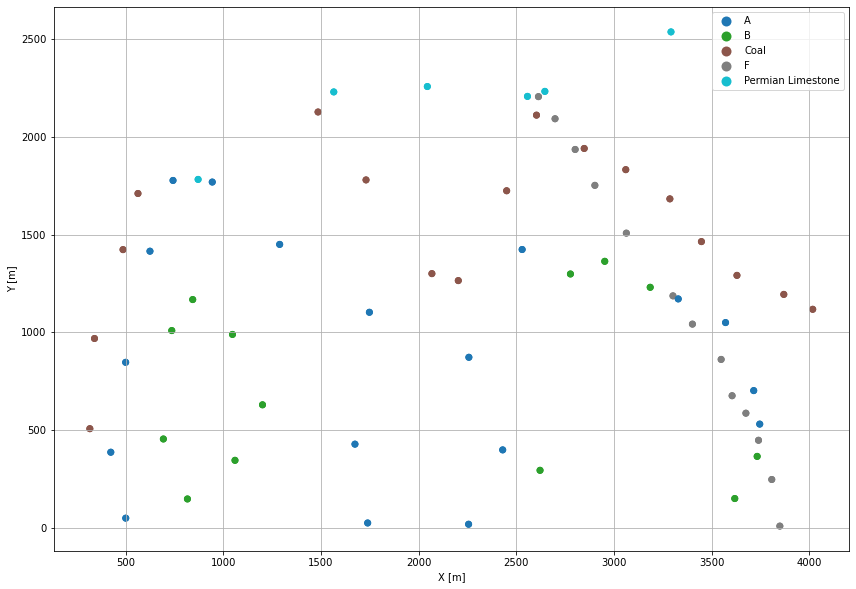

In [13]:
# Plot points at the contacts
fig, ax = plt.subplots(1, figsize=(15, 10))
contacts.plot(ax=ax, column='formation', legend=True, aspect='equal')
contacts_with_Z.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]');

In [14]:
# Read strike lines
gdf = gpd.read_file(current_directory+'/strike_lines/strike_lines.shp')
gdf

,X,Y,Z,formation,id,geometry
0,63.61,1737.94,350,Permian Limestone,1,POINT (63.612 1737.940)
1,1866.90,2375.60,350,Permian Limestone,1,POINT (1866.905 2375.597)
2,2304.65,2187.76,400,Permian Limestone,2,POINT (2304.654 2187.760)
3,3342.51,2560.03,400,Permian Limestone,2,POINT (3342.510 2560.030)
4,692.42,250.74,200,B1,3,POINT (692.418 250.743)
5,685.12,431.94,200,B1,3,POINT (685.119 431.937)
6,792.85,162.91,250,B1,4,POINT (792.851 162.905)
7,799.23,1125.82,250,B1,4,POINT (799.233 1125.821)
8,1094.85,378.84,200,B2,5,POINT (1094.849 378.837)
9,1100.17,931.84,200,B2,5,POINT (1100.166 931.840)


In [15]:
# Convert points into strike lines
linestring_gdf_PL = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'Permian Limestone'])
linestring_gdf_B1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'B1'])
linestring_gdf_B2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'B2'])
linestring_gdf_B3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'B3'])
linestring_gdf_A1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'A1'])
linestring_gdf_A2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'A2'])
linestring_gdf_A3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'A3'])
linestring_gdf_F = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'F'])
linestring_gdf_Coal1 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'Coal1'])
linestring_gdf_Coal2 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'Coal2'])
linestring_gdf_Coal3 = gg.vector.create_linestring_gdf(gdf=gdf[gdf['formation'] == 'Coal3'])

In [16]:
# Check that the strike lines are correct
linestring_gdf_PL.is_valid

0    True
1    True
dtype: bool

In [17]:
linestring_gdf_B1.is_valid

0    True
1    True
dtype: bool

In [18]:
linestring_gdf_B2.is_valid

0    True
1    True
dtype: bool

In [19]:
linestring_gdf_B3.is_valid

0    True
1    True
dtype: bool

In [20]:
linestring_gdf_A1.is_valid

0    True
1    True
dtype: bool

In [21]:
linestring_gdf_A2.is_valid

0    True
1    True
dtype: bool

In [22]:
linestring_gdf_A3.is_valid

0    True
1    True
dtype: bool

In [23]:
linestring_gdf_F.is_valid

0    True
1    True
dtype: bool

In [24]:
linestring_gdf_Coal1.is_valid

0    True
1    True
2    True
dtype: bool

In [25]:
linestring_gdf_Coal2.is_valid

0    True
1    True
dtype: bool

In [26]:
linestring_gdf_Coal3.is_valid

0    True
1    True
dtype: bool

In [27]:
#Calculate orientations from strike lines
orientations_PL = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_PL)
orientations_B1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B1)
orientations_B2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B2)
orientations_B3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_B3)
orientations_A1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A1)
orientations_A2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A2)
orientations_A3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_A3)
orientations_F = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_F)
orientations_Coal1 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Coal1)
orientations_Coal2 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Coal2)
orientations_Coal3 = gg.vector.calculate_orientations_from_strike_lines(gdf=linestring_gdf_Coal3)
orientations_PL

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,5.99,340.46,375.00,POINT (1894.420 2215.332),1.00,1894.42,2215.33,Permian Limestone


In [28]:
orientations_B1

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,26.33,270.28,225.00,POINT (742.405 492.851),1.00,742.41,492.85,B1


In [29]:
orientations_B2

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,14.14,89.39,225.00,POINT (994.397 662.063),1.00,994.40,662.06,B2


In [30]:
orientations_B3

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,15.12,89.99,225.00,POINT (2992.262 875.115),1.00,2992.26,875.12,B3


In [31]:
orientations_A1

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,18.30,90.98,225.00,POINT (1587.064 740.135),1.00,1587.06,740.13,A1


In [32]:
orientations_A2

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,19.39,270.06,175.00,POINT (2330.561 491.536),1.00,2330.56,491.54,A2


In [33]:
orientations_A3

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,16.73,90.02,75.00,POINT (3583.898 670.554),1.00,3583.90,670.55,A3


In [34]:
orientations_F

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,51.11,64.74,75.00,POINT (3626.427 591.663),1.00,3626.43,591.66,F


In [35]:
orientations_Coal1

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,14.05,89.98,225.00,POINT (1992.400 1687.504),1.00,1992.40,1687.50,Coal1
1,15.06,89.98,275.00,POINT (1799.409 1894.879),1.00,1799.41,1894.88,Coal1


In [36]:
orientations_Coal2

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,24.64,269.95,275.00,POINT (2360.737 1786.849),1.00,2360.74,1786.85,Coal2


In [37]:
orientations_Coal3

,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,15.02,89.97,175.00,POINT (3401.925 1843.808),1.00,3401.93,1843.81,Coal3


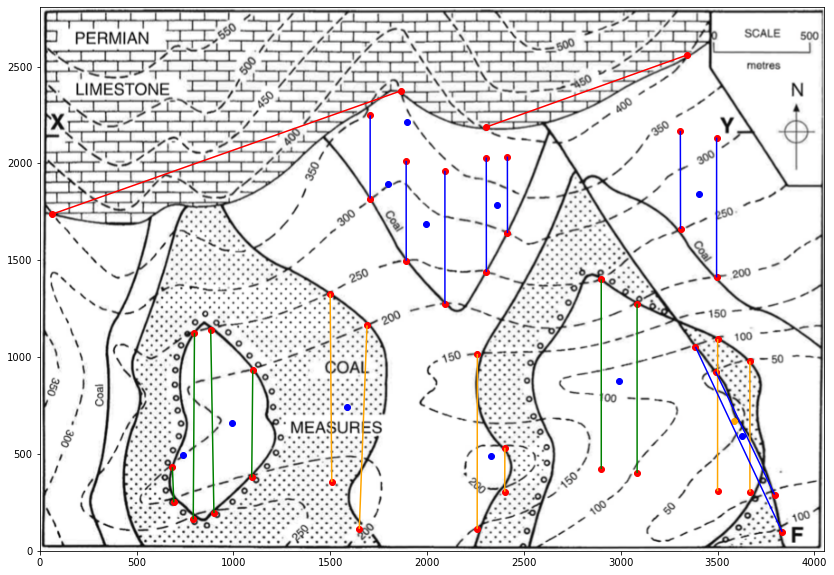

In [38]:
# Plot all this information to better understand the structure
fig, ax = plt.subplots(1,1,figsize=(15, 10))
ax.imshow(img, extent=[0, 4052, 0, 2807], cmap='gray')   
# Plot points
gdf.plot(ax=ax, aspect='equal', color='red')
# Plot strike lines
# Base of Permian limestone
linestring_gdf_PL.plot(ax=ax, aspect='equal', color='red')
orientations_PL.plot(ax=ax, aspect='equal', color='blue')
# Western fold, western flank, base of B
linestring_gdf_B1.plot(ax=ax, aspect='equal', color='green')
orientations_B1.plot(ax=ax, aspect='equal', color='blue')
# Western fold, eastern flank, base of B
linestring_gdf_B2.plot(ax=ax, aspect='equal', color='green')
orientations_B2.plot(ax=ax, aspect='equal', color='blue')
# Eastern fold, eastern flank, base of B
linestring_gdf_B3.plot(ax=ax, aspect='equal', color='green')
orientations_B3.plot(ax=ax, aspect='equal', color='blue')
# Central fold, western flank, base of A
linestring_gdf_A1.plot(ax=ax, aspect='equal', color='orange')
orientations_A1.plot(ax=ax, aspect='equal', color='blue')
# Central fold, eastern flank, base of A
linestring_gdf_A2.plot(ax=ax, aspect='equal', color='orange')
orientations_A2.plot(ax=ax, aspect='equal', color='blue')
# Eastern fold, eastern flank, base of A
linestring_gdf_A3.plot(ax=ax, aspect='equal', color='orange')
orientations_A3.plot(ax=ax, aspect='equal', color='orange')
# Fault
linestring_gdf_F.plot(ax=ax, aspect='equal', color='blue')
orientations_F.plot(ax=ax, aspect='equal', color='blue')
# Central fold, western flank, base of Coal
linestring_gdf_Coal1.plot(ax=ax, aspect='equal', color='blue')
orientations_Coal1.plot(ax=ax, aspect='equal', color='blue')
# Central fold, eastern flank, base of Coal
linestring_gdf_Coal2.plot(ax=ax, aspect='equal', color='blue')
orientations_Coal2.plot(ax=ax, aspect='equal', color='blue')
# Eastern fold,eastern flank, base of Coal
linestring_gdf_Coal3.plot(ax=ax, aspect='equal', color='blue')
orientations_Coal3.plot(ax=ax, aspect='equal', color='blue');

In [39]:
# Merge orientations
import pandas as pd
orientations = pd.concat([orientations_PL,orientations_F, orientations_B1, 
                          orientations_B2, orientations_B3, orientations_A1,
                          orientations_A2, orientations_A3, orientations_Coal1,
                          orientations_Coal2, orientations_Coal3]).reset_index()
orientations

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.99,340.46,375.00,POINT (1894.420 2215.332),1.00,1894.42,2215.33,Permian Limestone
1,0,51.11,64.74,75.00,POINT (3626.427 591.663),1.00,3626.43,591.66,F
2,0,26.33,270.28,225.00,POINT (742.405 492.851),1.00,742.41,492.85,B1
3,0,14.14,89.39,225.00,POINT (994.397 662.063),1.00,994.40,662.06,B2
4,0,15.12,89.99,225.00,POINT (2992.262 875.115),1.00,2992.26,875.12,B3
5,0,18.30,90.98,225.00,POINT (1587.064 740.135),1.00,1587.06,740.13,A1
6,0,19.39,270.06,175.00,POINT (2330.561 491.536),1.00,2330.56,491.54,A2
7,0,16.73,90.02,75.00,POINT (3583.898 670.554),1.00,3583.90,670.55,A3
8,0,14.05,89.98,225.00,POINT (1992.400 1687.504),1.00,1992.40,1687.50,Coal1
9,1,15.06,89.98,275.00,POINT (1799.409 1894.879),1.00,1799.41,1894.88,Coal1


In [40]:
# Rename orientations correctly
orientations['formation'] = ['Permian Limestone', 'F', 'B', 'B', 'B', 'A','A','A','Coal','Coal','Coal','Coal']
orientations

,index,dip,azimuth,Z,geometry,polarity,X,Y,formation
0,0,5.99,340.46,375.00,POINT (1894.420 2215.332),1.00,1894.42,2215.33,Permian Limestone
1,0,51.11,64.74,75.00,POINT (3626.427 591.663),1.00,3626.43,591.66,F
2,0,26.33,270.28,225.00,POINT (742.405 492.851),1.00,742.41,492.85,B
3,0,14.14,89.39,225.00,POINT (994.397 662.063),1.00,994.40,662.06,B
4,0,15.12,89.99,225.00,POINT (2992.262 875.115),1.00,2992.26,875.12,B
5,0,18.30,90.98,225.00,POINT (1587.064 740.135),1.00,1587.06,740.13,A
6,0,19.39,270.06,175.00,POINT (2330.561 491.536),1.00,2330.56,491.54,A
7,0,16.73,90.02,75.00,POINT (3583.898 670.554),1.00,3583.90,670.55,A
8,0,14.05,89.98,225.00,POINT (1992.400 1687.504),1.00,1992.40,1687.50,Coal
9,1,15.06,89.98,275.00,POINT (1799.409 1894.879),1.00,1799.41,1894.88,Coal


# Construction of the model in GemPy

In [41]:
# Import GemPy
import gempy as gp

In [42]:
# Create a geomodel object called model8
geo_model = gp.create_model('model8')

In [43]:
# Define model extent, resolution, surface points, and orientations
gp.init_data(geo_model, [0, 4052, 0, 2807, 0, 600], [100, 100, 100],
             surface_points_df=contacts_with_Z,
             orientations_df=orientations, default_values=True);

Active grids: ['regular']


In [44]:
# Check default series
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,F,Default series,1,#015482,1
1,Permian Limestone,Default series,2,#9f0052,2
2,Coal,Default series,3,#ffbe00,3
3,A,Default series,4,#728f02,4
4,B,Default series,5,#443988,5


In [45]:
# The base of the unit at the cores of the anticlines does not outcrop
# This is our "basement". Add this unit manually
geo_model.add_surfaces('C')

# Group units into series
gp.map_stack_to_surfaces(geo_model,
                         {'Fault': ('F'),'Strata1': ('Permian Limestone'),
                          'Strata2': ('Coal','A', 'B','C'),},
                         remove_unused_series=True)

# Tell GemPy there is a fault
geo_model.set_is_fault(['Fault'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault,1,Fault,True,True,False
Strata1,2,Erosion,True,False,False
Strata2,3,Erosion,True,False,False


In [46]:
# Check the data are correct
gg.utils.show_number_of_data_points(geo_model=geo_model)

,surface,series,order_surfaces,color,id,No. of Interfaces,No. of Orientations
0,F,Fault,1,#527682,1,13,1
1,Permian Limestone,Strata1,1,#9f0052,2,6,1
2,Coal,Strata2,1,#ffbe00,3,17,4
3,A,Strata2,2,#728f02,4,18,3
4,B,Strata2,3,#443988,5,13,3
5,C,Strata2,4,#ff3f20,6,0,0


In [47]:
# Set the topography of the model
geo_model.set_topography(source='gdal',filepath='dem_map8.tif');

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


In [48]:
# Plot the points on the contacts and topography in 3D 
# This will open a PyVista window. This may take some time, please wait
from pyvistaqt import BackgroundPlotter
gp.plot_3d(geo_model, plotter_type='background',show_topography=True);

In [49]:
# Now we have enough data to interpolate. This may take some time, please wait
gp.set_interpolator(geo_model, compile_theano=True,
                    theano_optimizer='fast_compile');                    

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                     values
range              4965.68
$C_o$            587094.12
drift equations  [3, 3, 3]


In [50]:
# Ignore warnings from np
import warnings
import numpy as np
warnings.filterwarnings('ignore',category=np.VisibleDeprecationWarning)

# Compute the geological model. This may take some time, please wait
gp.compute_model(geo_model);

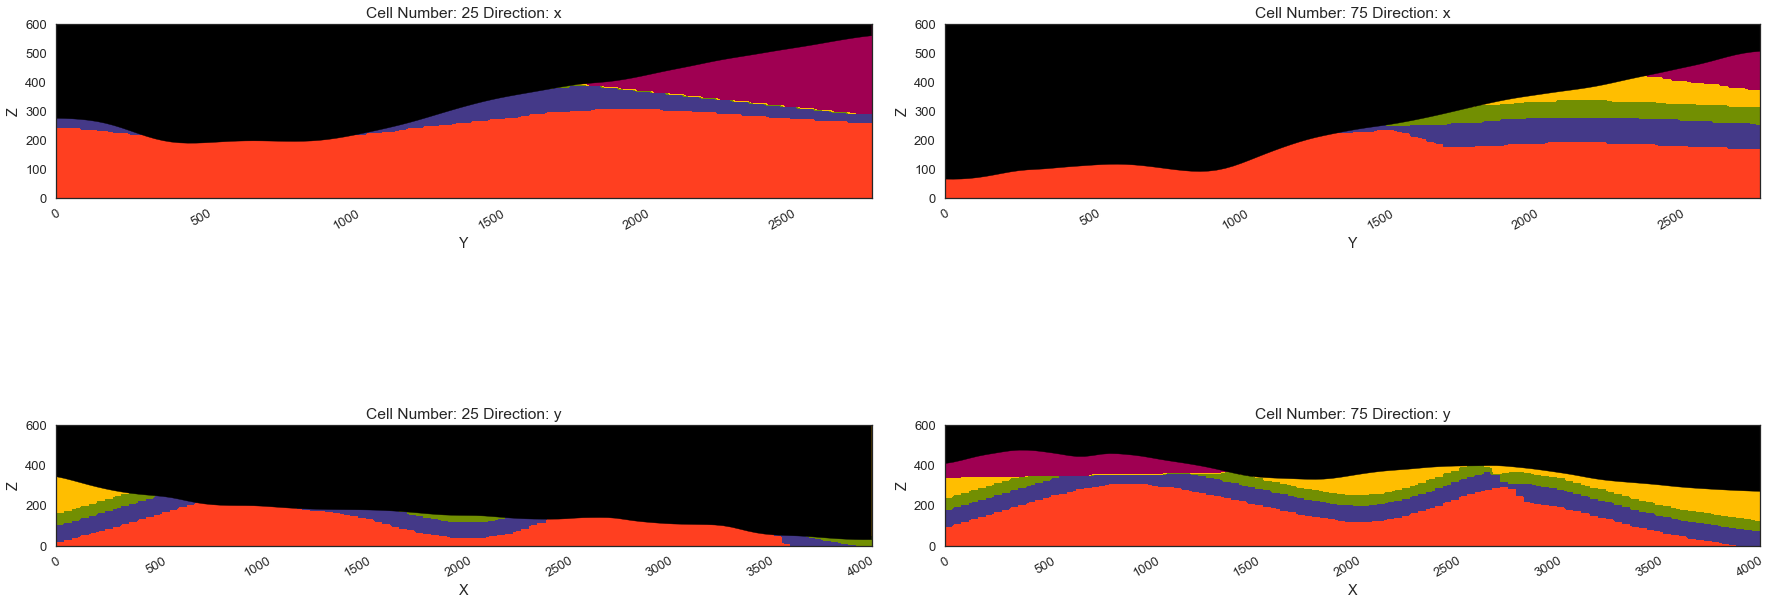

In [51]:
# Plot north-south and east-west sections without vertical exaggeration
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25, 75, 25, 75], 
           show_data=False, show_boundaries=False, show_topography=True, show=False);

In [52]:
# Plot the geomodel in 3D, this will open a PyVista window. This may take some time
gp.plot_3d(geo_model, plotter_type='background', show_topography=True, show_lith=False);